[*********************100%%**********************]  1 of 1 completed


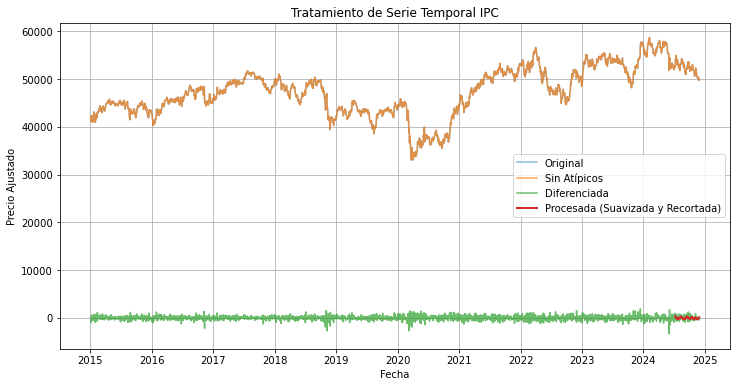

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.signal import savgol_filter

def obtener_datos_ipc():
    # IPC México (ejemplo: '^MXX')
    ipc = yf.download("^MXX", start="2015-01-01", end="2024-11-29")
    return ipc['Adj Close']

# Tratamiento de datos atípicos
def eliminar_atipicos(serie, factor=1.5):
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 - q1
    lim_inferior = q1 - factor * iqr
    lim_superior = q3 + factor * iqr
    return serie.clip(lower=lim_inferior, upper=lim_superior)

# Diferenciación para estacionariedad
def diferenciar(serie):
    return serie.diff().dropna()

# Suavización de la serie
def suavizar_serie(serie, window_length=7, polyorder=2):
    return savgol_filter(serie, window_length, polyorder)

# Recorte de la serie a los últimos valores representativos
def recortar_serie(serie, num_valores=100):
    return serie.tail(num_valores)

# Análisis
ipc = obtener_datos_ipc()

# Paso 1: Tratamiento de datos atípicos
ipc_sin_atipicos = eliminar_atipicos(ipc)

# Paso 2: Diferenciación
ipc_diferenciada = diferenciar(ipc_sin_atipicos)

# Paso 3: Suavización
ipc_suavizada = suavizar_serie(ipc_diferenciada, window_length=15, polyorder=2)

# Paso 4: Recorte
ipc_final = recortar_serie(pd.Series(ipc_suavizada, index=ipc_diferenciada.index))

plt.figure(figsize=(12, 6))
plt.plot(ipc, label="Original", alpha=0.5)
plt.plot(ipc_sin_atipicos, label="Sin Atípicos", alpha=0.7)
plt.plot(ipc_diferenciada, label="Diferenciada", alpha=0.7)
plt.plot(ipc_final, label="Procesada (Suavizada y Recortada)", linewidth=2)
plt.legend()
plt.title("Tratamiento de Serie Temporal IPC")
plt.xlabel("Fecha")
plt.ylabel("Precio Ajustado")
plt.grid()
plt.show()

[*********************100%%**********************]  1 of 1 completed
MAE: 1333.80
MSE: 3023107.12
RMSE: 1738.71


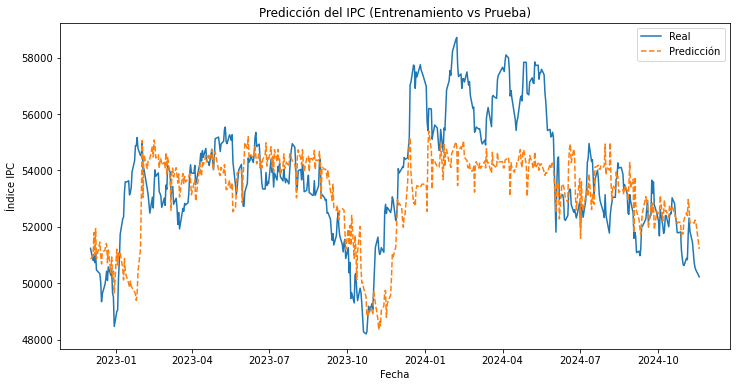

In [3]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Descarga de datos
symbol = "^MXX"  
start_date = "2015-01-01"
end_date = "2024-11-20"

data = yf.download(symbol, start=start_date, end=end_date)


data['Returns'] = data['Close'].pct_change()  # Retornos porcentuales
data['Moving_Avg'] = data['Close'].rolling(window=20).mean()  # Media móvil
data['Volatility'] = data['Close'].rolling(window=20).std()  # Volatilidad
data = data.dropna()  # Eliminar valores nulos

X = data[['Returns', 'Moving_Avg', 'Volatility']]
y = data['Close']

# Datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Entrenamiento del modelo (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Real')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicción', linestyle='--')
plt.title('Predicción del IPC (Entrenamiento vs Prueba)')
plt.xlabel('Fecha')
plt.ylabel('Índice IPC')
plt.legend()
plt.show()

In [4]:
import statsmodels.api as sm


# Agregar una constante para el modelo de regresión
X_train = sm.add_constant(X_train)

# Ajustar el modelo de regresión dinámica
dynamic_model = sm.OLS(y_train, X_train).fit()

# Resumen del modelo
print(dynamic_model.summary())

# Predicción para el conjunto de prueba
X_test = sm.add_constant(X_test)  # Asegurarse de incluir la constante en los datos de prueba
y_pred_dynamic = dynamic_model.predict(X_test)

# Validación del modelo con métricas de error
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_dynamic = mean_squared_error(y_test, y_pred_dynamic)
mae_dynamic = mean_absolute_error(y_test, y_pred_dynamic)

print(f"MSE Dynamic Regression: {mse_dynamic}")
print(f"MAE Dynamic Regression: {mae_dynamic}")


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 1.161e+04
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        07:57:43   Log-Likelihood:                -16396.
No. Observations:                1974   AIC:                         3.280e+04
Df Residuals:                    1970   BIC:                         3.282e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1215.1991    257.940      4.711      0.0

Epoch 100/1000, MSE: 0.0529
Epoch 200/1000, MSE: 0.0358
Epoch 300/1000, MSE: 0.0302
Epoch 400/1000, MSE: 0.0269
Epoch 500/1000, MSE: 0.0249
Epoch 600/1000, MSE: 0.0236
Epoch 700/1000, MSE: 0.0226
Epoch 800/1000, MSE: 0.0219
Epoch 900/1000, MSE: 0.0213
Epoch 1000/1000, MSE: 0.0208
MSE Neural Network Autoregression: 0.0121
MAE Neural Network Autoregression: 0.0850


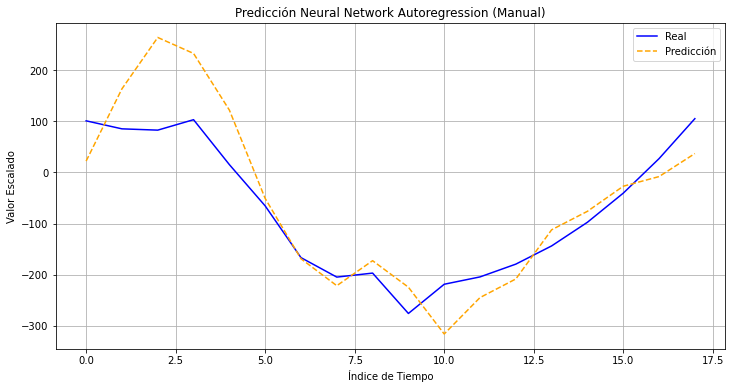

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\rogel\anaconda3

  added / updated specs:
    - cpuonly
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.9.0               |   py39haa95532_0         888 KB
    conda-build-3.26.1         |   py39haa95532_0         596 KB
    conda-index-0.5.0          |   py39haa95532_0         216 KB
    conda-package-streaming-0.11.0|   py39haa95532_0          30 KB
    cpuonly-2.0                |                0           2 KB  pytorch
    libjpeg-turbo-2.0.0        |       h196d8e1_0         618 KB
    libuv-1.44.2               |

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Preparación de los datos
n_lags = 12  # Número de rezagos
scaler = MinMaxScaler()

# Escalar los datos
scaled_data = scaler.fit_transform(ipc_final.values.reshape(-1, 1))

# Crear secuencias para el modelo NAR
X = []
y_target = []
for i in range(n_lags, len(scaled_data)):
    X.append(scaled_data[i - n_lags:i, 0])
    y_target.append(scaled_data[i, 0])

X = np.array(X)
y_target = np.array(y_target)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2, random_state=42, shuffle=False)

# Inicializar pesos y bias manualmente
np.random.seed(42)
weights = np.random.rand(n_lags)
bias = np.random.rand(1)

# Definir función de activación (ReLU)
def relu(x):
    return np.maximum(0, x)

# Entrenamiento manual de una red neuronal simple
epochs = 1000
learning_rate = 0.01

for epoch in range(epochs):
    # Forward pass
    linear_output = np.dot(X_train, weights) + bias
    predictions = relu(linear_output)
    
    # Cálculo del error
    errors = predictions - y_train
    
    # Backward pass: Gradiente descendente
    grad_weights = np.dot(errors, X_train) / len(y_train)
    grad_bias = np.mean(errors)
    
    # Actualización de pesos y bias
    weights -= learning_rate * grad_weights
    bias -= learning_rate * grad_bias
    
    # Registro del error
    if (epoch + 1) % 100 == 0:
        mse = np.mean(errors**2)
        print(f"Epoch {epoch+1}/{epochs}, MSE: {mse:.4f}")

# Evaluación del modelo en el conjunto de prueba
linear_output_test = np.dot(X_test, weights) + bias
y_pred_test = relu(linear_output_test)

mse_nar = mean_squared_error(y_test, y_pred_test)
mae_nar = mean_absolute_error(y_test, y_pred_test)

print(f"MSE Neural Network Autoregression: {mse_nar:.4f}")
print(f"MAE Neural Network Autoregression: {mae_nar:.4f}")

# Inversión del escalado para las predicciones
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualización de las predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Real', linestyle='-', color='blue')
plt.plot(y_pred_test_rescaled, label='Predicción', linestyle='--', color='orange')
plt.title('Predicción Neural Network Autoregression (Manual)')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Valor Escalado')
plt.legend()
plt.grid()
plt.show()
